In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as pltgit 
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import re

In [2]:
#Change the name of the file to match your path
data_minhashing=pd.read_csv("/Users/madalena/Desktop/minhashing_results_subset.csv")
df=data_minhashing
df.shape
df.columns


Index(['signature', 'rating'], dtype='object')

## CLUSTER

DBSCAN


In [3]:
# == 1. Convert stringified signatures into numeric arrays
#Prepare data for clustering:
#Convert integer to float
df['signature'] = df['signature'].apply(
    lambda s: np.array(re.findall(r'-?\d+', str(s)), dtype=int)
)

#Transform  df['signature'] in lists of length 100 
X = np.array(df['signature'].tolist())
y = df['rating'].values  # true labels

In [4]:
#check X and y shape 
print(X.shape)
print(y.shape)

(500000, 100)
(500000,)


In [21]:
#If you want to run it with a subsample of 10% of the subset to save some time
# pick e.g. 10,000 points for DBSCAN (adjust if needed)
subset_size = 100000
indices_sub = np.random.choice(len(X), size=subset_size, replace=False)

X_sub = X[indices_sub]
print("Feature matrix shape:", X_sub.shape)

Feature matrix shape: (100000, 100)


In [6]:
#Use UMAP before
#If you want to run it with a subsample, change "X" for "X_sub"
import umap

umap_model = umap.UMAP(
    n_neighbors=30,      # controls local vs global structure
    min_dist=0.0,        # tighter clusters
    n_components=15,      # 2–10 recommended
    metric='euclidean',
    random_state=42
)
X_umap = umap_model.fit_transform(X)

/Users/madalena/miniforge3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [7]:
print(X_umap.shape)

(500000, 15)


In [8]:
# To choose Eps, use the elbow method

# Use k=2 because the first neighbor is the point itself
nbrs = NearestNeighbors(n_neighbors=2).fit(X_umap)
distances, indices = nbrs.kneighbors(X_umap)

# Take distance to the nearest neighbor (excluding itself)
nearest_dist = np.sort(distances[:,1])  # skip distance to self

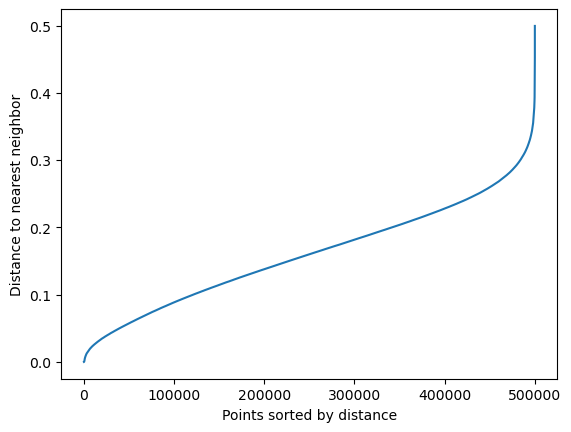

In [9]:
plt.plot(nearest_dist)
plt.ylabel("Distance to nearest neighbor")
plt.xlabel("Points sorted by distance")
plt.show()

In [10]:
eps = np.percentile(nearest_dist, 90)
print(eps)

0.25965657370841255


In [11]:
eps = 0.26 #adjust manually after checking the curve in the plot
min_samples = 15

# 3. Run DBSCAN 
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
clusters = dbscan.fit_predict(X_umap)
print("DBSCAN cluster labels distribution:")

#Print Cluster distribution
unique, counts = np.unique(clusters, return_counts=True)
print("Clusters distribution:", dict(zip(unique, counts)))

DBSCAN cluster labels distribution:
Clusters distribution: {np.int64(-1): np.int64(109179), np.int64(0): np.int64(389421), np.int64(1): np.int64(35), np.int64(2): np.int64(21), np.int64(3): np.int64(14), np.int64(4): np.int64(31), np.int64(5): np.int64(48), np.int64(6): np.int64(15), np.int64(7): np.int64(48), np.int64(8): np.int64(34), np.int64(9): np.int64(141), np.int64(10): np.int64(21), np.int64(11): np.int64(45), np.int64(12): np.int64(15), np.int64(13): np.int64(20), np.int64(14): np.int64(76), np.int64(15): np.int64(57), np.int64(16): np.int64(15), np.int64(17): np.int64(17), np.int64(18): np.int64(18), np.int64(19): np.int64(32), np.int64(20): np.int64(29), np.int64(21): np.int64(25), np.int64(22): np.int64(34), np.int64(23): np.int64(25), np.int64(24): np.int64(15), np.int64(25): np.int64(45), np.int64(26): np.int64(73), np.int64(27): np.int64(64), np.int64(28): np.int64(32), np.int64(29): np.int64(11), np.int64(30): np.int64(6), np.int64(31): np.int64(13), np.int64(32): np.i

In [ ]:
dbs_clusters=clusters+1 

In [17]:
#EVALUATION using DAVIES-BOULDIN INDEX
def DB(X, dbs_clusters):
    db = davies_bouldin_score(X, dbs_clusters)
    return db


#Evaluate HDBSCAN
db_DBscan = DB(X, clusters)
print(f"Davies-Bouldin Index (DB) for HDBSCAN: {db_DBscan:.4f}")

Davies-Bouldin Index (DB) for HDBSCAN: 3.0160


/Users/madalena/miniforge3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


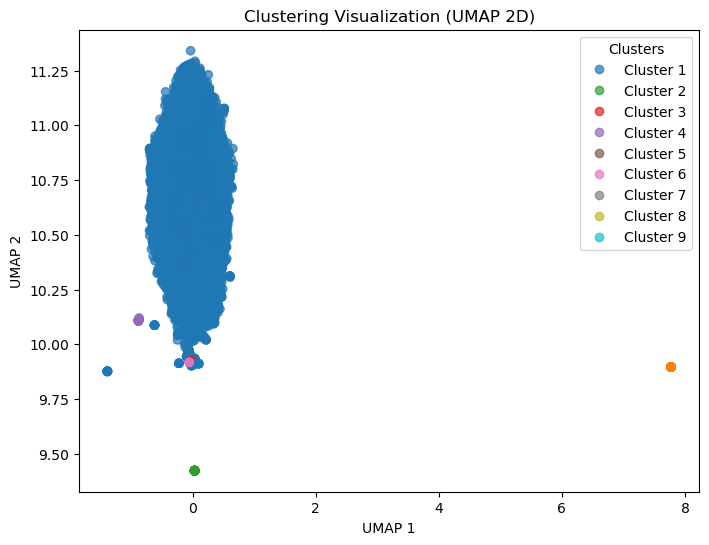

In [18]:
#VISUALIZATION of CLUSTERS
# Reduce to 2D using UMAP
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1],
                      c=dbs_clusters, cmap='tab10', alpha=0.7)

# Legend for cluster IDs
handles, labels = scatter.legend_elements()
plt.legend(handles, [f"Cluster {i}" for i in np.unique(dbs_clusters)], 
           title="Clusters")

plt.title("Clustering Visualization (UMAP 2D)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

rating     1.0    2.0    3.0    4.0     5.0
cluster                                    
-1        7820   5853   8939  20141   66426
 0       25663  19332  33136  77124  234166
 1           1      1      6     18       9
 2           0      0      1      1      19
 3           0      0      0      8       6
 4           1      1     19      7       3
 5           0      1      0      0      47
 6           0      0      0      0      15
 7           0      0      0     43       5
 8           2      1      0      6      25
 9          10      3      5     29      94
 10          0      0      0      0      21
 11          0      0     41      3       1
 12          0      7      2      5       1
 13          0      2      0      5      13
 14          3      3      4      9      57
 15          4      4      2     21      26
 16          0      0      0      3      12
 17          0      0      0      4      13
 18          0      0      0      0      18
 19          0      2      2    

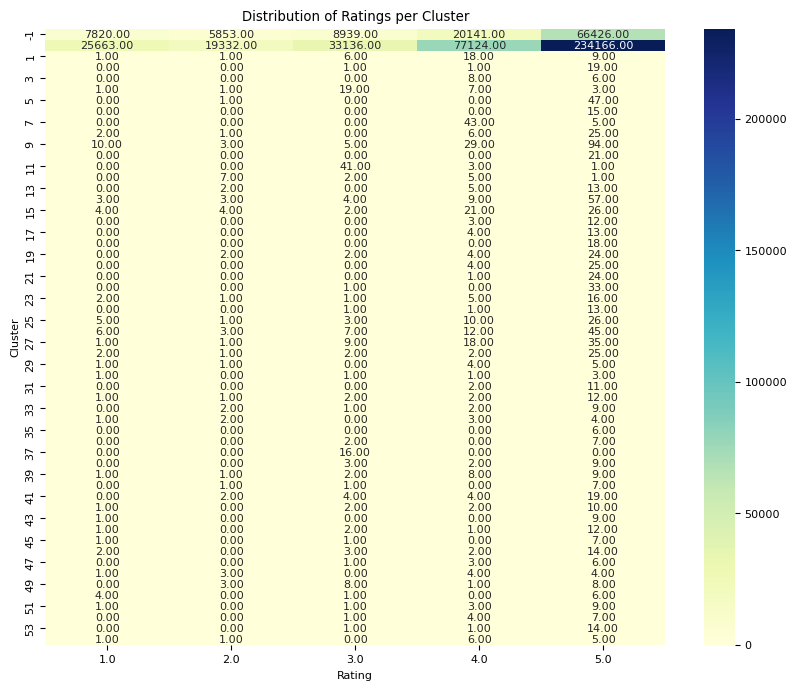

In [33]:
#ANALYSIS OF CLUSTERS WITH RESPECT TO RATINGS
# Create dataframe containing ratings and cluster assignments
df_results = pd.DataFrame({
    'rating': y,
    'cluster': clusters
})

#Table showing distribution of ratings per cluster
cluster_summary = pd.crosstab(df_results['cluster'], df_results['rating'])
print(cluster_summary)

#print heatmap 
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(cluster_summary, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Distribution of Ratings per Cluster")
plt.xlabel("Rating")
plt.ylabel("Cluster")
plt.show()